In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima

# global vars
from util_scripts.plotting_fcts_and_vars import years, growth_boroughs, boroughs, west_boroughs, columns, types

# plotting per borrough
from util_scripts.plotting_fcts_and_vars import plot_boroughs, plot_all_boroughs, borough_restaurant_TS


In [2]:
# Importing the datasets
restaurants_per_capita = pd.read_csv('../data/restaurantS_units_per_capita.csv')
gdp_per_capita = pd.read_csv('../data/gdp_per_capita.csv')

In [3]:
restaurants_per_capita.head()

,Unnamed: 0,Area name,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1,City of London,0.002769,0.002910,0.002823,0.002451,0.002466,0.002179,0.002752,0.002514,0.002138,0.002244,0.002140,0.002332,0.002495,0.002698,0.002848,0.002804,0.003035
1,2,Barking and Dagenham,0.000448,0.000433,0.000426,0.000491,0.000479,0.000476,0.000467,0.000461,0.000379,0.000367,0.000372,0.000478,0.000459,0.000402,0.000506,0.000429,0.000369
2,3,Barnet,0.003087,0.002847,0.002849,0.002793,0.002699,0.002642,0.002598,0.002341,0.002491,0.002581,0.002429,0.002714,0.002834,0.002640,0.002730,0.002568,0.002795
3,4,Bexley,0.001288,0.001176,0.001084,0.001130,0.001153,0.001252,0.001206,0.001145,0.001061,0.001139,0.001115,0.001190,0.001169,0.001138,0.001064,0.001159,0.001136
4,5,Brent,0.001757,0.001783,0.001821,0.001657,0.001685,0.001933,0.001987,0.001716,0.001751,0.001818,0.001856,0.001932,0.001959,0.001860,0.002017,0.002137,0.001992


In [4]:
#MULTiply restaurants_per_capita by 1000
restaurants_per_capita.iloc[:, 2:] = restaurants_per_capita.iloc[:, 2:].multiply(1000)
restaurants_per_capita.head()

,Unnamed: 0,Area name,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1,City of London,2.769231,2.909648,2.823180,2.450980,2.465753,2.179487,2.751678,2.513587,2.137767,2.243959,2.139640,2.332196,2.494577,2.698413,2.848101,2.803738,3.034979
1,2,Barking and Dagenham,0.448430,0.432900,0.425532,0.490884,0.478796,0.476190,0.466667,0.460526,0.378788,0.366748,0.371747,0.477897,0.459242,0.401837,0.506187,0.429185,0.369198
2,3,Barnet,3.087349,2.846715,2.849003,2.793296,2.699055,2.642008,2.598226,2.340936,2.491103,2.581032,2.428910,2.713626,2.834467,2.640264,2.730193,2.568134,2.795031
3,4,Bexley,1.287879,1.176471,1.083815,1.129944,1.153324,1.251647,1.205584,1.144578,1.061321,1.139089,1.115023,1.190476,1.169265,1.137595,1.063830,1.159115,1.136364
4,5,Brent,1.756955,1.783167,1.820728,1.657459,1.684636,1.933333,1.987179,1.715686,1.751208,1.818182,1.856287,1.932084,1.958525,1.860203,2.017448,2.136752,1.991614


In [5]:
gdp_per_capita.head()

,Unnamed: 0,Area code,Area name,1998,1999,2000,2001,2002,2003,2004,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0,E61000001,Greater London Authority,27560,28743,30677,31214,32094,33850,35465,...,45030,46793,49249,50347,52874,54319,55940,57500,54225,59855
1,1,E09000007,The City of London,57740,59528,62764,63783,65349,69590,73635,...,95834,100686,108546,121235,134224,136968,137267,133436,114609,168278
2,2,E09000002,Barking and Dagenham,16258,15962,15794,15607,15510,16049,16868,...,19660,20858,20746,20405,19320,18919,19211,19964,18136,18923
3,3,E09000003,Barnet,15470,16354,16907,17291,18036,19048,19707,...,22705,22977,24097,24706,25473,25539,26100,26775,25406,28833
4,4,E09000004,Bexley,15854,16658,17245,17927,18577,19498,19918,...,24384,26716,26948,27847,29117,28166,28219,29376,26603,27942


In [6]:
#drop Greater London Authority from gdp_per_capita
gdp_per_capita['Area name'] = gdp_per_capita['Area name'][gdp_per_capita['Area name'] != 'Greater London Authority']
#rename The City of London to City of London
gdp_per_capita['Area name'] = gdp_per_capita['Area name'].replace('The City of London', 'City of London')

gdp_per_capita.head()

,Unnamed: 0,Area code,Area name,1998,1999,2000,2001,2002,2003,2004,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,0,E61000001,NaN,27560,28743,30677,31214,32094,33850,35465,...,45030,46793,49249,50347,52874,54319,55940,57500,54225,59855
1,1,E09000007,City of London,57740,59528,62764,63783,65349,69590,73635,...,95834,100686,108546,121235,134224,136968,137267,133436,114609,168278
2,2,E09000002,Barking and Dagenham,16258,15962,15794,15607,15510,16049,16868,...,19660,20858,20746,20405,19320,18919,19211,19964,18136,18923
3,3,E09000003,Barnet,15470,16354,16907,17291,18036,19048,19707,...,22705,22977,24097,24706,25473,25539,26100,26775,25406,28833
4,4,E09000004,Bexley,15854,16658,17245,17927,18577,19498,19918,...,24384,26716,26948,27847,29117,28166,28219,29376,26603,27942


In [7]:
#remove first row from gdp_per_capita
gdp_per_capita = gdp_per_capita.iloc[1:]
gdp_per_capita.head()

,Unnamed: 0,Area code,Area name,1998,1999,2000,2001,2002,2003,2004,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1,1,E09000007,City of London,57740,59528,62764,63783,65349,69590,73635,...,95834,100686,108546,121235,134224,136968,137267,133436,114609,168278
2,2,E09000002,Barking and Dagenham,16258,15962,15794,15607,15510,16049,16868,...,19660,20858,20746,20405,19320,18919,19211,19964,18136,18923
3,3,E09000003,Barnet,15470,16354,16907,17291,18036,19048,19707,...,22705,22977,24097,24706,25473,25539,26100,26775,25406,28833
4,4,E09000004,Bexley,15854,16658,17245,17927,18577,19498,19918,...,24384,26716,26948,27847,29117,28166,28219,29376,26603,27942
5,5,E09000005,Brent,17472,18850,19488,19767,20470,21326,21819,...,24087,25168,27078,28377,29387,29654,29525,31639,30091,31487


In [8]:
#drop first 2 columns from gdp_per_capita
gdp_per_capita = gdp_per_capita.iloc[:, 2:]
gdp_per_capita.head()

,Area name,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1,City of London,57740,59528,62764,63783,65349,69590,73635,77950,80556,...,95834,100686,108546,121235,134224,136968,137267,133436,114609,168278
2,Barking and Dagenham,16258,15962,15794,15607,15510,16049,16868,16954,18469,...,19660,20858,20746,20405,19320,18919,19211,19964,18136,18923
3,Barnet,15470,16354,16907,17291,18036,19048,19707,20330,21507,...,22705,22977,24097,24706,25473,25539,26100,26775,25406,28833
4,Bexley,15854,16658,17245,17927,18577,19498,19918,20864,21862,...,24384,26716,26948,27847,29117,28166,28219,29376,26603,27942
5,Brent,17472,18850,19488,19767,20470,21326,21819,22790,23750,...,24087,25168,27078,28377,29387,29654,29525,31639,30091,31487


In [9]:
#drop 1998 - 2000 from gdp_per_capita
gdp_per_capita = gdp_per_capita.drop(columns=['1998', '1999', '2000'])

#drop 2018-2021 from gdp_per_capita
gdp_per_capita = gdp_per_capita.drop(columns=['2018', '2019', '2020', '2021'])
gdp_per_capita.head()

,Area name,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
1,City of London,63783,65349,69590,73635,77950,80556,88247,92028,90056,92086,94292,95834,100686,108546,121235,134224,136968
2,Barking and Dagenham,15607,15510,16049,16868,16954,18469,19222,19206,17344,19057,19157,19660,20858,20746,20405,19320,18919
3,Barnet,17291,18036,19048,19707,20330,21507,22306,21895,20401,20982,21369,22705,22977,24097,24706,25473,25539
4,Bexley,17927,18577,19498,19918,20864,21862,22840,23186,21815,22406,22678,24384,26716,26948,27847,29117,28166
5,Brent,19767,20470,21326,21819,22790,23750,24226,23692,21715,22316,22536,24087,25168,27078,28377,29387,29654


In [10]:
#reset index to first row
gdp_per_capita = gdp_per_capita.reset_index(drop=True)
gdp_per_capita.head()

,Area name,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,City of London,63783,65349,69590,73635,77950,80556,88247,92028,90056,92086,94292,95834,100686,108546,121235,134224,136968
1,Barking and Dagenham,15607,15510,16049,16868,16954,18469,19222,19206,17344,19057,19157,19660,20858,20746,20405,19320,18919
2,Barnet,17291,18036,19048,19707,20330,21507,22306,21895,20401,20982,21369,22705,22977,24097,24706,25473,25539
3,Bexley,17927,18577,19498,19918,20864,21862,22840,23186,21815,22406,22678,24384,26716,26948,27847,29117,28166
4,Brent,19767,20470,21326,21819,22790,23750,24226,23692,21715,22316,22536,24087,25168,27078,28377,29387,29654


## Running Time Series Analysis

In [11]:
#set index to Area name
restaurants_per_capita = restaurants_per_capita.set_index('Area name')

In [12]:
#create dataset for Hackney
borough = 'Hackney'
hackney = borough_restaurant_TS(restaurants_per_capita, borough)
hackney.head()


2001-01-01    1.308540
2002-01-01    1.336898
2003-01-01    1.317523
2004-01-01    1.434159
2005-01-01    1.394170
Name: Hackney, dtype: float64

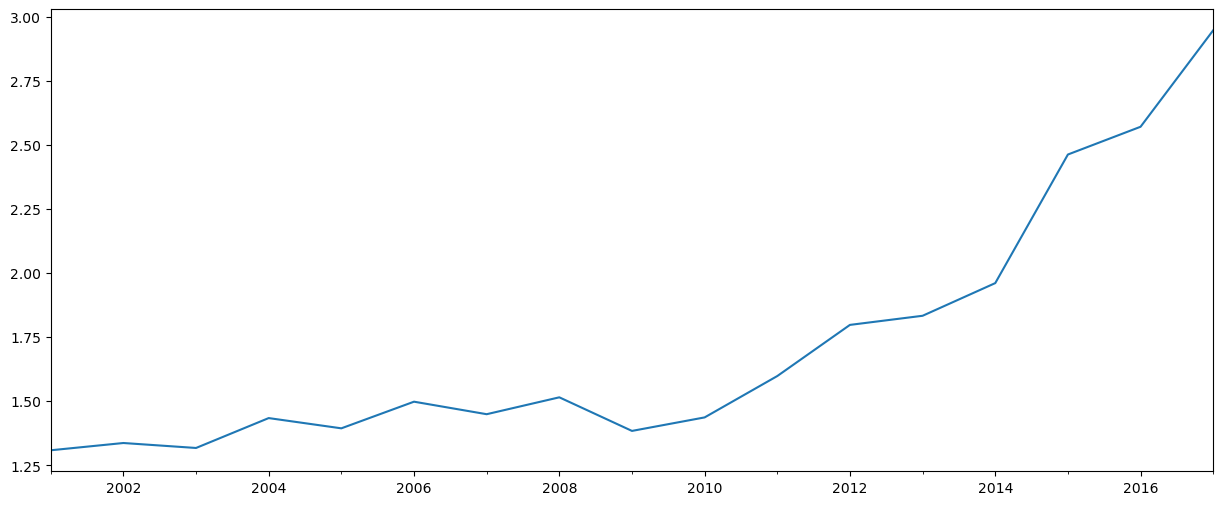

In [13]:
#plot Hackney
hackney.plot(figsize=(15, 6))
plt.show()

In [14]:
gdp_per_capita = gdp_per_capita.set_index('Area name')

In [15]:
#create dataset for Hackney
hackney_gdp = borough_restaurant_TS(gdp_per_capita, borough)

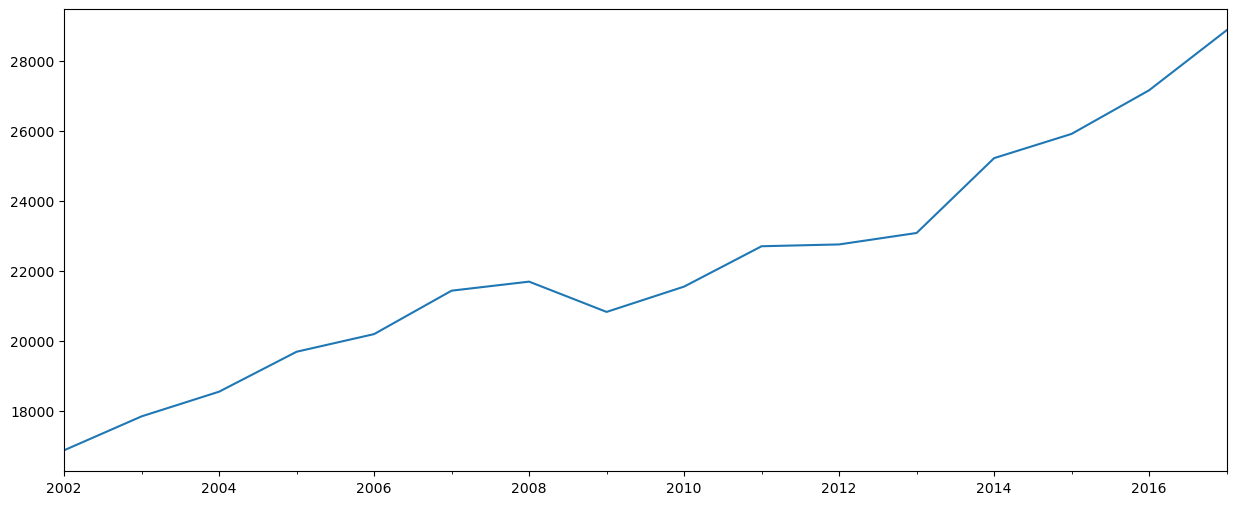

In [16]:
#plot Hackney
hackney_gdp.plot(figsize=(15, 6))
plt.show()

In [17]:
#add column for GDP growth
#cnvert to dataframe
hackney_gdp = pd.DataFrame(hackney_gdp)
hackney_gdp.head()

#add column for GDP growth

hackney_gdp.head()

,Hackney
2002-01-01,16869
2003-01-01,17838
2004-01-01,18543
2005-01-01,19684
2006-01-01,20188


In [18]:
exog = hackney_gdp
exog["GDP_shift_1"] = exog.iloc[:, 0].fillna(method='bfill').shift(1).values
exog["GDP_shift_2"] = exog.iloc[:, 0].fillna(method='bfill').shift(2).values
exog["GDP_shift_3"] = exog.iloc[:, 0].fillna(method='bfill').shift(3).values

exog.head()

,Hackney,GDP_shift_1,GDP_shift_2,GDP_shift_3
2002-01-01,16869,NaN,NaN,NaN
2003-01-01,17838,16869.0,NaN,NaN
2004-01-01,18543,17838.0,16869.0,NaN
2005-01-01,19684,18543.0,17838.0,16869.0
2006-01-01,20188,19684.0,18543.0,17838.0


In [19]:
# fill NaNs with the average of other values in row
first_row_mean = exog.iloc[0, :].mean()
second_row_mean = exog.iloc[1, :].mean()
third_row_mean = exog.iloc[2, :].mean()

exog.iloc[0, :] = exog.iloc[0, :].fillna(first_row_mean)
exog.iloc[1, :] = exog.iloc[1, :].fillna(second_row_mean)
exog.iloc[2, :] = exog.iloc[2, :].fillna(third_row_mean)

exog.head()

,Hackney,GDP_shift_1,GDP_shift_2,GDP_shift_3
2002-01-01,16869,16869.0,16869.0,16869.0
2003-01-01,17838,16869.0,17353.5,17353.5
2004-01-01,18543,17838.0,16869.0,17750.0
2005-01-01,19684,18543.0,17838.0,16869.0
2006-01-01,20188,19684.0,18543.0,17838.0


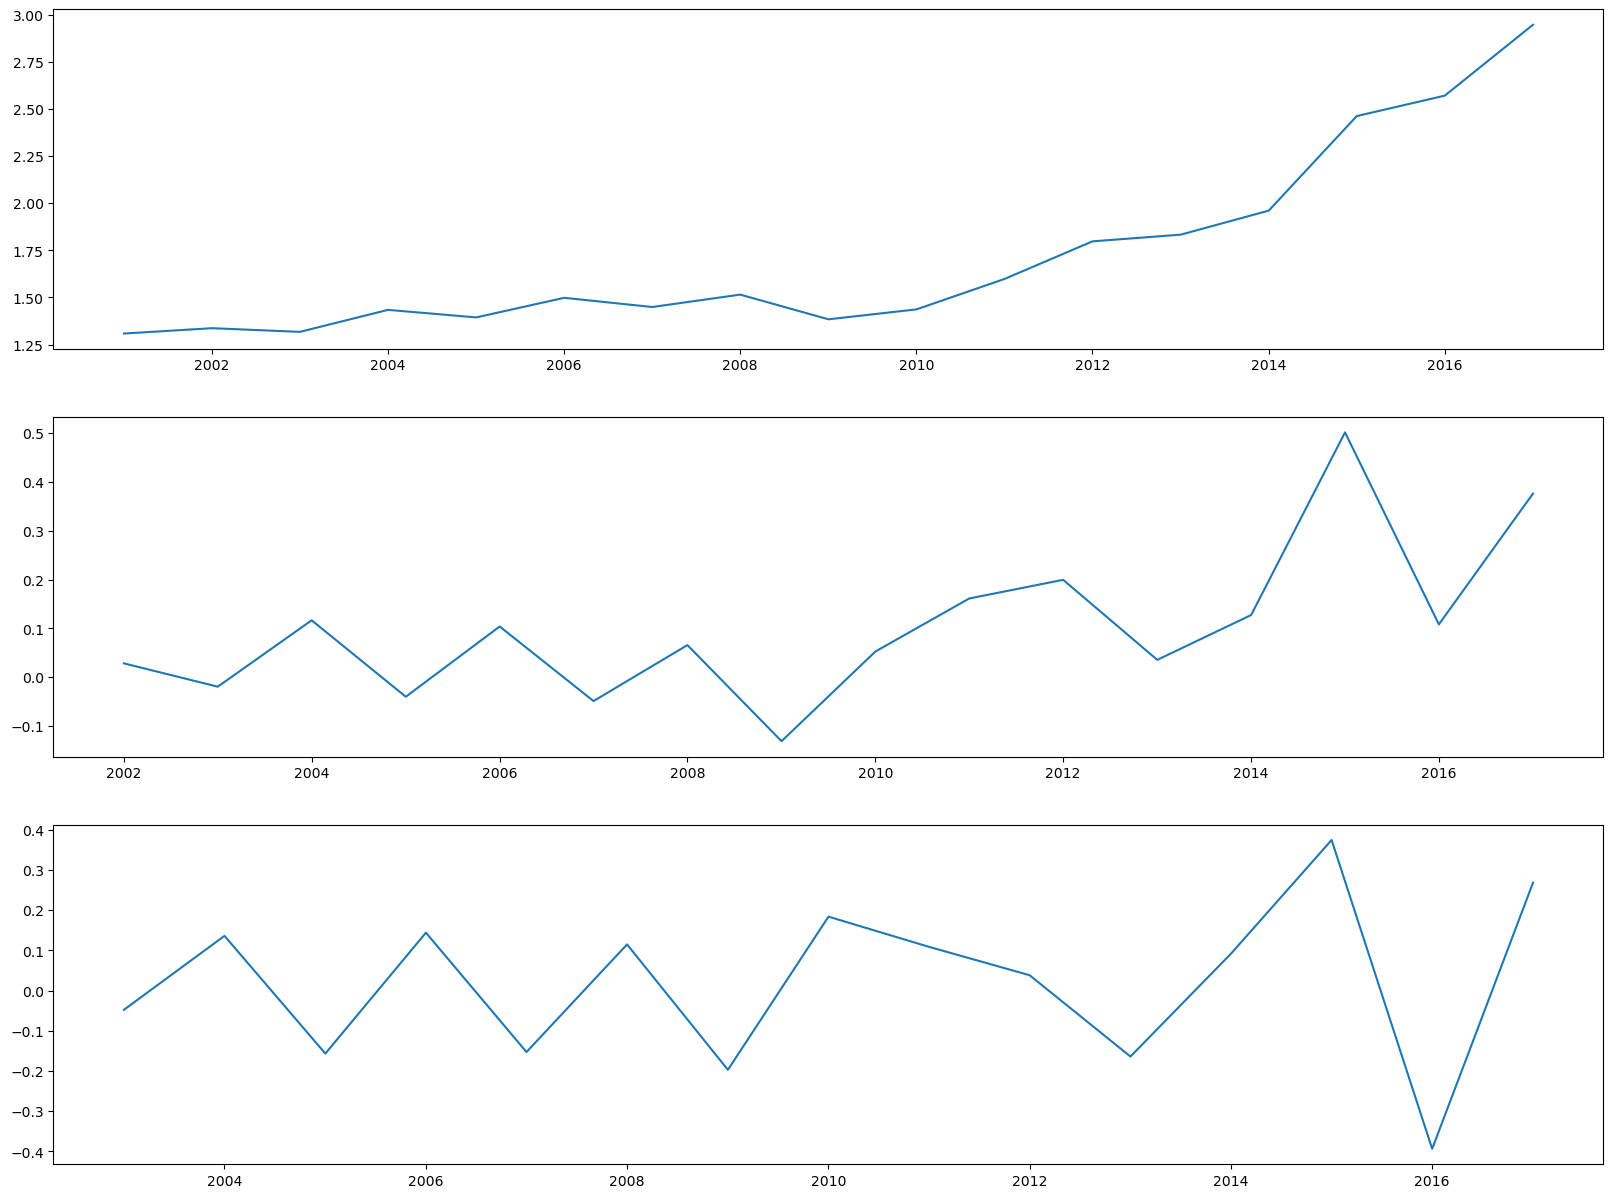

In [20]:
# We look at the original TS, 1st and 2nd difference to check stationarity
hackney_diff_1 = hackney.diff().dropna()
hackney_diff_2 = hackney.diff().diff().dropna()

fig, axs = plt.subplots(nrows=3, figsize=(20, 15))

axs[0].plot(hackney)
axs[1].plot(hackney_diff_1)
axs[2].plot(hackney_diff_2)

In [21]:
hackney_train = hackney[hackney.index < datetime(2011, 7, 1)]
hackney_test  = hackney[visits.index >= datetime(2011, 7, 1)]

exog_train = exog[exog.index < datetime(2012, 7, 1)]
exog_test = exog[exog.index >= datetime(2012, 7, 1)]

NameError: name 'datetime' is not defined